In [7]:
import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
%matplotlib inline

from datetime import datetime
import time
import csv
sns.set_style("darkgrid")
results_2019 = pd.read_csv('./Runners_all_results_2019.csv', header = 0, encoding='latin-1', error_bad_lines=False)
results_2019['OfficialTime'] = results_2019['OfficialTime'].apply(lambda x: datetime.combine(datetime.min, datetime.strptime(x, '%H:%M:%S').time()) - datetime.min)
results_2019['OfficialTime'] = results_2019['OfficialTime'].apply(lambda x: x.total_seconds()/3600)
results_2019.head(2)

b'Skipping line 26144: expected 20 fields, saw 21\n'


,BibNumber,FullName,SortName,AgeOnRaceDay,Gender,City,StateAbbrev,StateName,Zip,CountryOfResAbbrev,CountryOfResName,CountryOfCtzAbbrev,CountryOfCtzName,OfficialTime,RankOverall,RankOverGender,RankOverDivision,EventGroup,SubGroupLabel,SubGroup
0,2,Lawrence Cherono,"Cherono, Lawrence",30,M,Eldoret,NaN,NaN,NaN,KEN,Kenya,KEN,Kenya,2.132500,1,1,1,Runners,NaN,NaN
1,6,Lelisa Desisa,"Desisa, Lelisa",29,M,Ambo,NaN,NaN,NaN,ETH,Ethiopia,ETH,Ethiopia,2.133056,2,2,2,Runners,NaN,NaN


import city elevation data

In [8]:
cities_elevation = pd.read_csv('cities.csv', header = 0, sep=' *, *', quotechar = '"', error_bad_lines=False, warn_bad_lines=False)
cities_elevation['Elevation'] = cities_elevation['Elevation'].apply(pd.to_numeric, errors='coerce')
results_2019 = results_2019.merge(cities_elevation.set_index("City"), left_on='City', right_on="City", how='left')

<ipython-input-8-3a27001ad02b>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  cities_elevation = pd.read_csv('cities.csv', header = 0, sep=' *, *', quotechar = '"', error_bad_lines=False, warn_bad_lines=False)


In [9]:
results_2019.Gender[results_2019.Gender == 'M'] = 2
results_2019.Gender[results_2019.Gender == 'F'] = 0
results_2019.head(2)
points = results_2019[['Elevation', 'OfficialTime']].dropna()
points = points.iloc[:10000,]
points = points.to_numpy()

<ipython-input-9-59491e6e50fe>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_2019.Gender[results_2019.Gender == 'M'] = 2
<ipython-input-9-59491e6e50fe>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_2019.Gender[results_2019.Gender == 'F'] = 0


### Data standardisation with [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

In [10]:
##jeśli dane są w jakiś sposób skorelowane to znaczy, że występuje redundancja danych, te dane nic nowego nie wnoszą
##są niepotrzebne

## if necessary to scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_points = scaler.fit_transform(points)


## [AgglomerativeClustering()](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering)

Text(0.5, 0, 'City of residence elevation [m]')

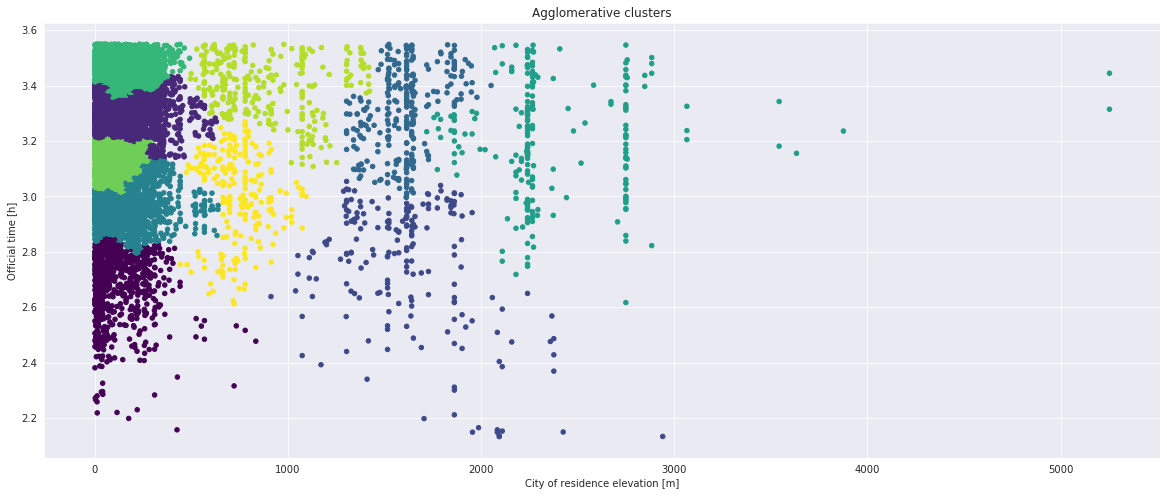

In [11]:
#powyżej - dendrogram - pokazuje proces łaczenia punktów w klastry
#znajduje dwa najbliższe sobie punkty i kolejne dwa sobie najbliższe i zamyka je w klastrach
#następnie zamyka w klastrach najbliższe sobie małe klastry
# i tak dalej aż zostanie tylke klastrów ile chcemy (kiedy zostanie przekroczony punkt podobieństwa)
#pytanie jak określić podobieństwo klastrów do siebie?
# możemy użyć metody pojedyńczego łaczenia
from sklearn.cluster import AgglomerativeClustering
agglomerative = AgglomerativeClustering(distance_threshold=20, n_clusters=None).fit(scaled_points)
plt.figure(figsize=(20,8))
plt.scatter(points[:, 0], points[:, 1], c=agglomerative.labels_, s=20, cmap='viridis');
plt.title("Agglomerative clusters")
plt.ylabel("Official time [h]")
plt.xlabel("City of residence elevation [m]")

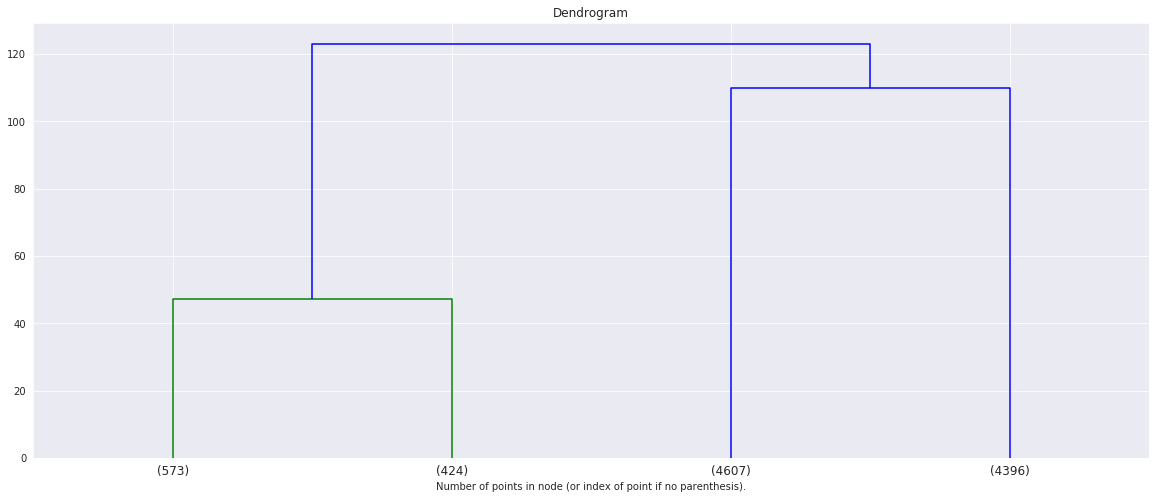

In [12]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
plt.figure(figsize=(20,8))
plot_dendrogram(agglomerative, truncate_mode='level', p=1)
plt.title("Dendrogram")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()
# dendrogram dla clusteringu poniżej

Text(0.5, 0, 'Age')

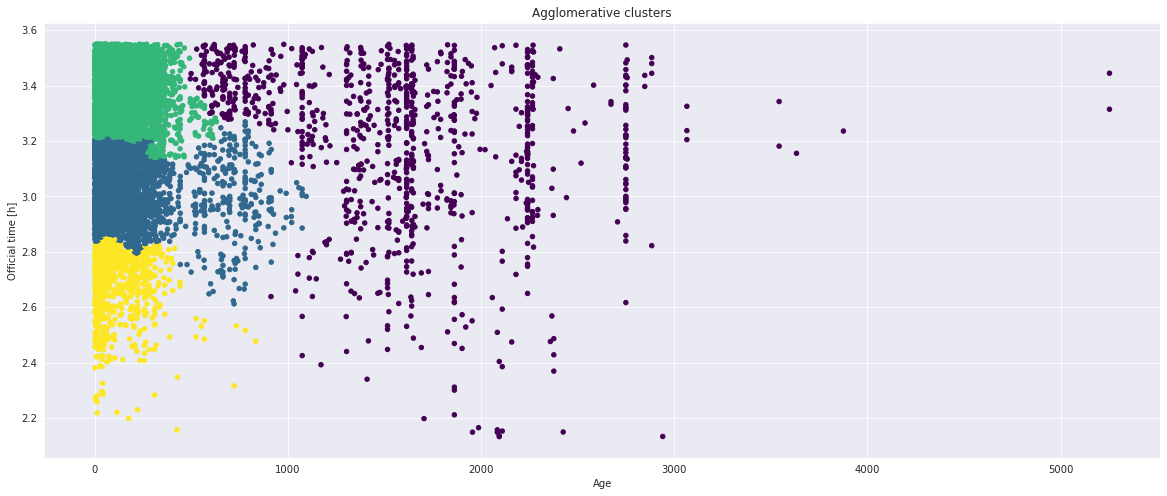

In [13]:
from sklearn.cluster import AgglomerativeClustering
agglomerative = AgglomerativeClustering(n_clusters=4)\
    .fit(scaled_points)
plt.figure(figsize=(20,8))
plt.scatter(points[:, 0], points[:, 1], c=agglomerative.labels_, s=20, cmap='viridis');
plt.title("Agglomerative clusters")
plt.ylabel("Official time [h]")
plt.xlabel("Age")

# clustering w oparciu o czas i wysokość, ilość próbek zawężona do pierwszych 10000